# TWEET ANALYSIS
This piece of work is not complete and is part of my learning process for Natural Language Processing. It will be updated as and when I find time.

### Environment set up

In [1]:
import numpy as np
import pandas as pd
import string
import csv
import re
import os
import nltk
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import itertools
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import csv
import itertools
from datetime import datetime
from itertools import groupby
%matplotlib inline
get_ipython().magic('matplotlib inline')
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

C:\Users\homeuser\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
C:\Users\homeuser\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data set up

In [2]:
startTime = datetime.now()
folderPath = "C:/Users/homeuser/Documents/MEJ/DS Challenge/Hackathon/Data/SampleTesting/tweetFiles"
os.chdir(folderPath)

### Read data files

In [3]:
recCount = 0
tempTweet = []
tempURL = []
for filename in os.listdir(os.getcwd()):
    temp = pd.read_excel(filename)
    recCount = int(recCount + temp.count()[1])
    tempTweet.extend(list(temp['Contents']))
    temp_url = temp.apply(lambda x: hash(tuple(x[2])), axis = 1)
    tempURL.extend(list(temp_url))
tweet = pd.DataFrame(columns=['URL','TweetContent'])
tweet['TweetContent'] = tempTweet
tweet['URL'] = tempURL
tweet['OriginalURL'] = temp['URL']
tweet['Author'] = temp['Author']
del filename, temp,tempTweet,tempURL

### Abuse dictionary of words

In [4]:
folderPath = "C:/Users/homeuser/Documents/MEJ/DS Challenge/Hackathon/Data/SampleTesting"
os.chdir(folderPath)
abuseKeywords = pd.read_csv("abuseKeywords.csv")
del folderPath

### Tweet processing

In [5]:
tweet_lower = tweet['TweetContent'].apply(lambda x: x.lower())
tweet_https = tweet_lower.apply(lambda x: str(x).split('https:')[0] if('https:') in x else x)
tweet_punctuations = tweet_https.apply(lambda x:''.join([i for i in x 
                                                  if i not in string.punctuation]))
tweet_Tokens = tweet_punctuations.apply(lambda x: nltk.word_tokenize(x))
tweet_TokensCols = tweet_Tokens.apply(pd.Series)
tweet_TokensCols = tweet_TokensCols.rename(columns = lambda x : 'Tweet_' + str(x))
tweet_TokensCols.replace(to_replace=np.nan, value=0, inplace=True)
del tweet_lower,tweet_https,tweet_Tokens

### Abuse keywords processing

In [6]:
punctuation = ['?',')','(',',','/','#']
abuse_punctuations = abuseKeywords['AbuseDictionary'].apply(lambda x:''.join([i for i in x 
                                                  if i not in punctuation]))
abuse_Tokens = pd.DataFrame(columns=['AbuseDictionary'])
abuse_Tokens['AbuseDictionary'] = abuse_punctuations.apply(lambda x: nltk.word_tokenize(x))
abuse_TokensCols = abuse_Tokens['AbuseDictionary'].apply(pd.Series)
abuse_TokensCols = abuse_TokensCols.rename(columns = lambda x : 'Abuse_' + str(x))
del abuse_Tokens,abuse_punctuations,punctuation

In [7]:
counterDict = {}
for i in range(0,11):
    tempCounter = Counter(abuse_TokensCols.iloc[:,i])
    tempDict = dict(tempCounter)
    counterDict.update(tempDict)
abuseWords = list(counterDict.keys())
abuseWords = [x for x in abuseWords if str(x) != 'nan']
abuseWords = list(pd.read_csv("abuseCorpus.csv")['Keyword'].unique())
del i,tempCounter,tempDict,counterDict

### Distance calculation

In [8]:
def jaccard(str1, str2):
    str1 = set(str1)
    str2 = set(str2)
    return float(len(str1 & str2)) / len(str1 | str2)
    
def DistJaccard(x):
    match = 0
    for each in abuseWords:
        match = match + jaccard(x, each)
    match = round(match,2)
    return(match)
   
def DistEdit(x):
    match = 0
    for each in abuseWords:
        match = match + nltk.edit_distance(x, each)
    match = round(match,2)
    return(match)

In [9]:
jDist = tweet_TokensCols.applymap(lambda x: DistJaccard(x) if(hash(x)!=0) else 0)
jDistance = list(map(int,jDist.sum(axis=1)))
jaccardDistance = pd.DataFrame(columns=['URL','JDoriginal','JDnormalised'])
jaccardDistance['URL'] = tweet['URL']
jaccardDistance['JDoriginal'] = jDistance
normalized_JD = [round((i-min(jDistance))/(max(jDistance)-min(jDistance)),3) for i in jDistance]
jaccardDistance['JDnormalised'] = normalized_JD
del jDist,jDistance,normalized_JD

### Sentiment analysis

In [10]:
sia = SentimentIntensityAnalyzer()
nlp = pd.DataFrame(columns=['URL','JaccardDistance','Positivity','Negativity','Neutrality','Complexity'])
nlp['Positivity'] = tweet_punctuations.apply(lambda x: sia.polarity_scores(x)['pos'])
nlp['Negativity'] = tweet_punctuations.apply(lambda x: sia.polarity_scores(x)['neg'])
nlp['Neutrality'] = tweet_punctuations.apply(lambda x: sia.polarity_scores(x)['neu'])
nlp['Complexity'] = tweet_punctuations.apply(lambda x: sia.polarity_scores(x)['compound'])
nlp['URL'] = jaccardDistance['URL']
nlp['JaccardDistance'] = jaccardDistance['JDnormalised']
nlp['OriginalURL'] = tweet['OriginalURL']
nlp['Author'] = tweet['Author']

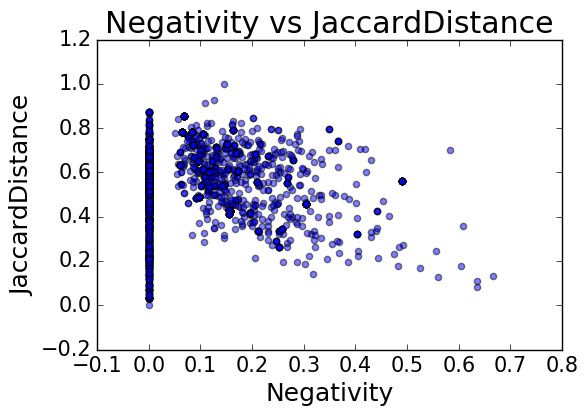

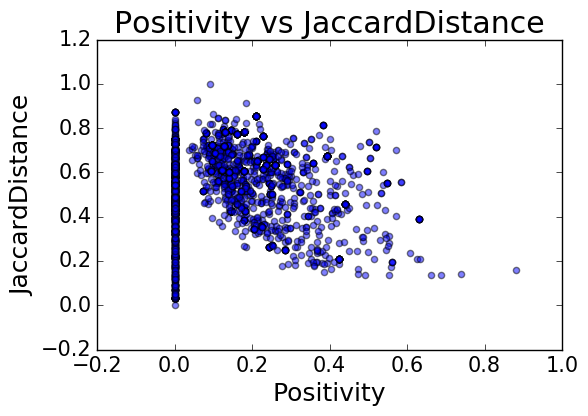

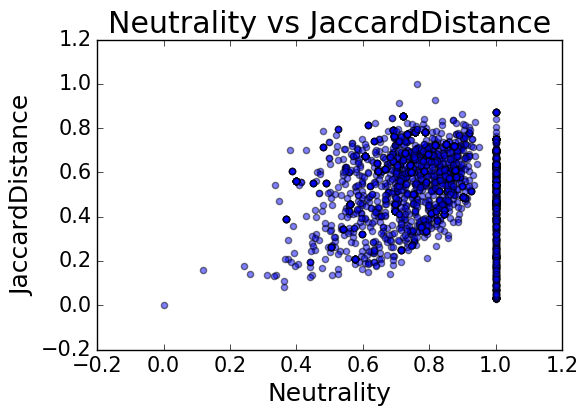

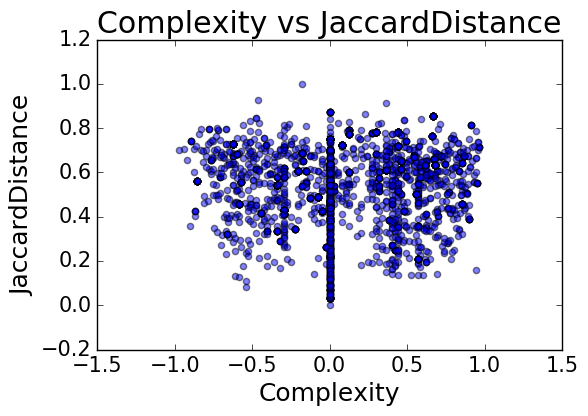

In [11]:
plt.scatter(nlp['Negativity'],nlp['JaccardDistance'], alpha=0.5)
plt.title('Negativity vs JaccardDistance')
plt.xlabel('Negativity')
plt.ylabel('JaccardDistance')
plt.show()

plt.scatter(nlp['Positivity'],nlp['JaccardDistance'], alpha=0.5)
plt.title('Positivity vs JaccardDistance')
plt.xlabel('Positivity')
plt.ylabel('JaccardDistance')
plt.show()

plt.scatter(nlp['Neutrality'],nlp['JaccardDistance'], alpha=0.5)
plt.title('Neutrality vs JaccardDistance')
plt.xlabel('Neutrality')
plt.ylabel('JaccardDistance')
plt.show()

plt.scatter(nlp['Complexity'],nlp['JaccardDistance'], alpha=0.5)
plt.title('Complexity vs JaccardDistance')
plt.xlabel('Complexity')
plt.ylabel('JaccardDistance')
plt.show()

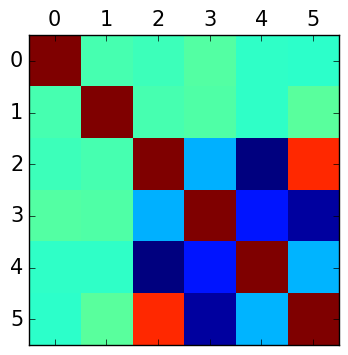

In [12]:
plt.matshow(nlp.corr())

### Annotation of tweets with Unsupervised learning (K-Means)

In [13]:
kmeansModel = KMeans(n_clusters=2, random_state=0).fit(nlp.iloc[:,1:5])
predicted= kmeansModel.predict(nlp.iloc[:,1:5])
nlp['kMeansLabel'] = predicted
del predicted

## Machine Learning Model creation for Tweet analysis

### Test/training split

In [14]:
X = nlp.iloc[:,1:5]
Y = nlp.iloc[:,6]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

### Annotation of potential abusers with Unsupervised learning (K-Means)

In [15]:
author = nlp.groupby('Author').mean()
authorAnalysis = author.filter(['JaccardDistance','Positivity','Negativity','Neutrality','Complexity'], axis=1)
kmeansModel = KMeans(n_clusters=2, random_state=0).fit(authorAnalysis)
predicted= kmeansModel.predict(authorAnalysis)
authorAnalysis['kMeansLabel'] = predicted

## Machine Learning Model creation to identify potential Abusers

### Test/training split

In [16]:
x = authorAnalysis.iloc[:,0:4]
y = authorAnalysis.iloc[:,5]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

### Timer

In [17]:
print('Overall execution took [', datetime.now() - startTime, '] seconds.')

Overall execution took [ 0:00:27.765734 ] seconds.


## Plan for future

1) Topic modeling (i.e. labeling) of severity of abuse words and one-hot encoding of tweets to create a feature vector. This feature vector will have four elements, each indicating the presence of each level of abuse severity

2) Combine one-hot encoded feature vector along with sentimental analysis for better prediction    

3) Network analysis to identify the influential network of abusers to perform targetted screening of tweets   

4) Evaluation of the quality of tweet labeling against labeled proxy social datasets

5) N-gram (upto 3) based dictionary to reduce false positives

6) Generate text cloud to add more prominent abuse words to abuse dictionary